# Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, silhouette_samples, silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Analyze Data

              MEAN_RR      MEDIAN_RR           SDRR          RMSSD  \
count   369289.000000  369289.000000  369289.000000  369289.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean       846.650104     841.965890     109.352531      14.977498   
std        124.603984     132.321005      77.117025       4.120766   
min        547.492221     517.293295      27.233947       5.529742   
25%        760.228533     755.750735      64.205641      11.830959   
50%        822.951438     819.689595      82.608243      14.415918   
75%        924.117422     916.821570     118.237002      17.927144   
max       1322.016957    1653.122250     563.486949      26.629477   

                 SDSD     SDRR_RMSSD             HR          pNN25  \
count   369289.000000  369289.000000  369289.000000  369289.000000   
unique            N

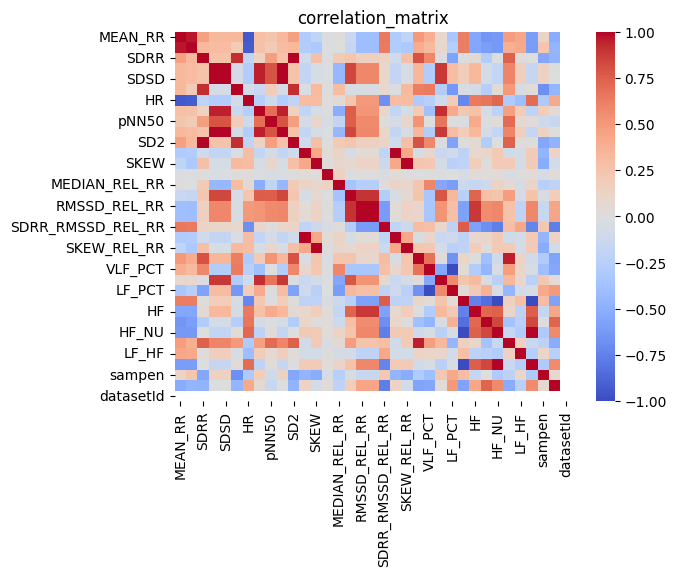

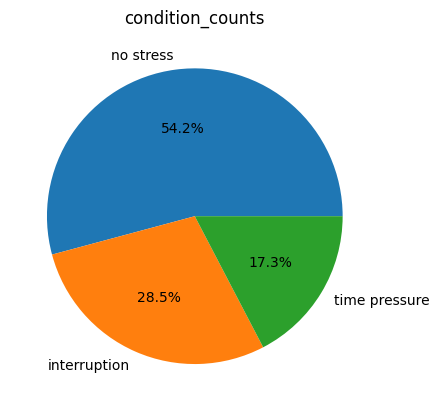

In [2]:
def analyze_data(file_path):
    df = pd.read_csv(file_path)
    pd.set_option('display.max_columns', None)
    print(df.describe(include='all'))

    numeric_data = df.select_dtypes(include=['number'])
    correlation_matrix = numeric_data.corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm')
    plt.title('correlation_matrix')
    plt.show()

    condition_counts = df['condition'].value_counts()
    labels = condition_counts.index
    sizes = condition_counts.values
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title('condition_counts')
    plt.show()
    
analyze_data('../input/swell-heart-rate-variability-hrv/hrv dataset/data/final/train.csv')

# Supervised Learning

In [3]:
def preprocess_data_supervised(file_path):
    df = pd.read_csv(file_path)

    condition_encoding = {'no stress': 0, 'time pressure': 1, 'interruption': 2}
    df['condition'] = df['condition'].map(condition_encoding)

    features = df.iloc[:, :-2]
    target = df.iloc[:, -1]

    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(features)

    pca = PCA(n_components=0.95, random_state=42)
    pca_features = pca.fit_transform(standardized_features)

    return pca_features, target

In [4]:
X_train, y_train = preprocess_data_supervised('../input/swell-heart-rate-variability-hrv/hrv dataset/data/final/train.csv')
X_test, y_test = preprocess_data_supervised('../input/swell-heart-rate-variability-hrv/hrv dataset/data/final/test.csv')

In [5]:
def evaluate_classification(model, X_train, y_train, X_test, y_test, cv):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(report)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print('cv_scores.mean:', f'{cv_scores.mean():.4f}')

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues')
    plt.title('confusion_matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# (1) Logistic Regression

              precision    recall  f1-score   support

           0       0.63      0.87      0.73     22158
           1       0.60      0.29      0.39      7093
           2       0.52      0.30      0.38     11782

    accuracy                           0.61     41033
   macro avg       0.58      0.49      0.50     41033
weighted avg       0.59      0.61      0.57     41033

cv_scores.mean: 0.6018


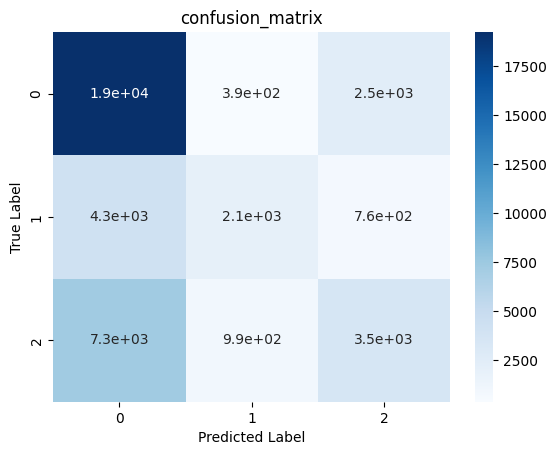

In [6]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(
    solver='lbfgs',
    penalty='l2'
)
logistic_regression.fit(X_train, y_train)

evaluate_classification(logistic_regression, X_train, y_train, X_test, y_test, cv=10)

# (2) Decision Tree

              precision    recall  f1-score   support

           0       0.72      0.90      0.80     22158
           1       0.74      0.35      0.48      7093
           2       0.72      0.61      0.66     11782

    accuracy                           0.72     41033
   macro avg       0.73      0.62      0.65     41033
weighted avg       0.72      0.72      0.70     41033

cv_scores.mean: 0.7423


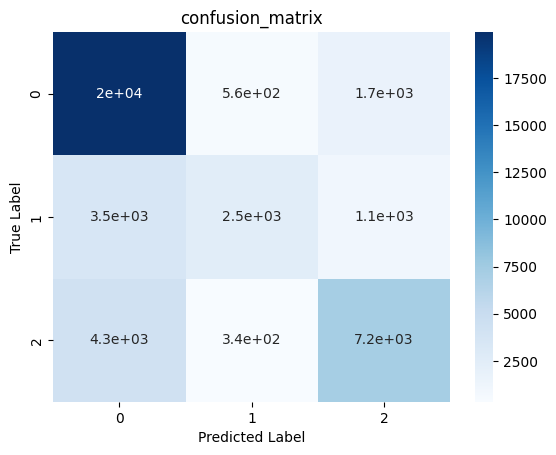

In [7]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=8,
    max_features='log2'
)
decision_tree.fit(X_train, y_train)

evaluate_classification(decision_tree, X_train, y_train, X_test, y_test, cv=10)

# (3) Random Forest

              precision    recall  f1-score   support

           0       0.76      0.95      0.85     22158
           1       0.83      0.51      0.64      7093
           2       0.87      0.66      0.75     11782

    accuracy                           0.79     41033
   macro avg       0.82      0.71      0.74     41033
weighted avg       0.81      0.79      0.78     41033

cv_scores.mean: 0.8152


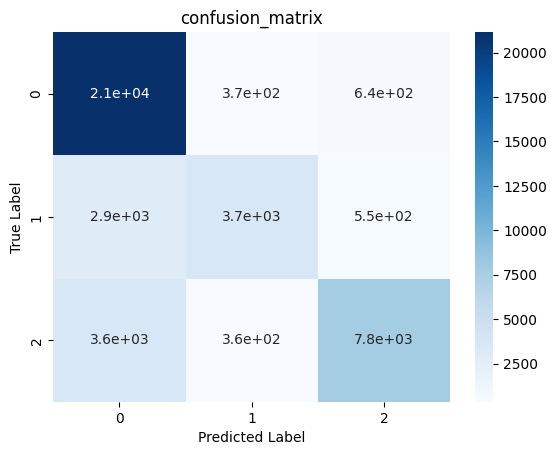

In [8]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(
    criterion='gini',
    max_depth=8,
    max_features='log2',
    n_estimators=4
)
random_forest.fit(X_train, y_train)

evaluate_classification(random_forest, X_train, y_train, X_test, y_test, cv=10)

# Unsupervised Learning

In [9]:
def preprocess_data_unsupervised(file_path):
    df = pd.read_csv(file_path)

    condition_encoding = {'no stress': 0, 'time pressure': 1, 'interruption': 2}
    df['condition'] = df['condition'].map(condition_encoding)

    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(df)

    pca = PCA(n_components=0.95, random_state=42)
    pca_features = pca.fit_transform(standardized_features)

    return pca_features

In [10]:
X_test = preprocess_data_unsupervised('../input/swell-heart-rate-variability-hrv/hrv dataset/data/final/test.csv')

In [11]:
def evaluate_clustering(X_test, labels):
    silhouette = silhouette_score(X_test, labels)
    print('silhouette_score:', f'{silhouette:.4f}')

    silhouette_vals = silhouette_samples(X_test, labels)
    y_ticks = []
    y_lower, y_upper = 0, 0

    for i, cluster in enumerate(set(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()

        y_upper += len(cluster_silhouette_vals)
        color = plt.cm.viridis(float(i) / len(set(labels)))

        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    plt.axvline(x=silhouette, color="red", linestyle="--")
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster')
    plt.yticks(y_ticks, range(len(set(labels))))
    plt.title('silhouette_samples')
    plt.show()

# (4) K-means

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette_score: 0.2561


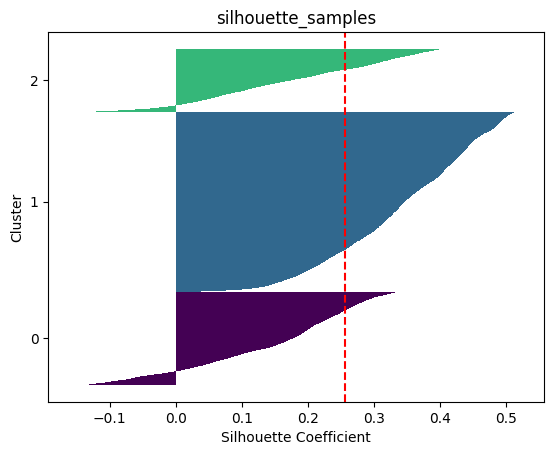

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_test)
labels = kmeans.predict(X_test)

evaluate_clustering(X_test, labels)

# (5) Gaussian Mixture

silhouette_score: 0.0928


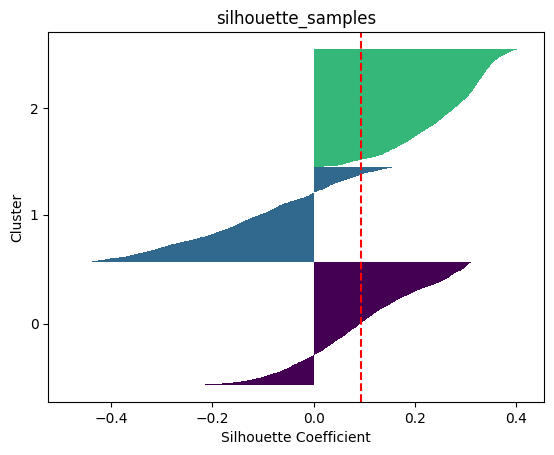

In [13]:
from sklearn.mixture import GaussianMixture

gaussian_mixture = GaussianMixture(n_components=3)
gaussian_mixture.fit(X_test)
labels = gaussian_mixture.predict(X_test)

evaluate_clustering(X_test, labels)

# (6) BIRCH

silhouette_score: 0.2117


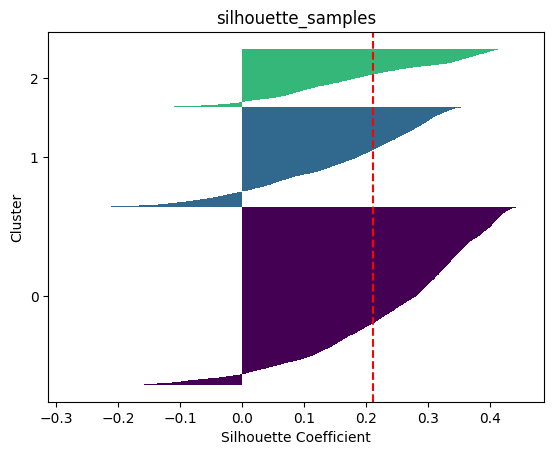

In [14]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=3)
birch.fit(X_test)
labels = birch.predict(X_test)

evaluate_clustering(X_test, labels)